# Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

2022-07-16 21:47:11.020064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-16 21:47:11.020115: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ! pip install tensorflow
# ! pip install tensorflow-gpu
#! pip install sklearn

# Load Database

In [3]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')
# df.head()

# Plot 1

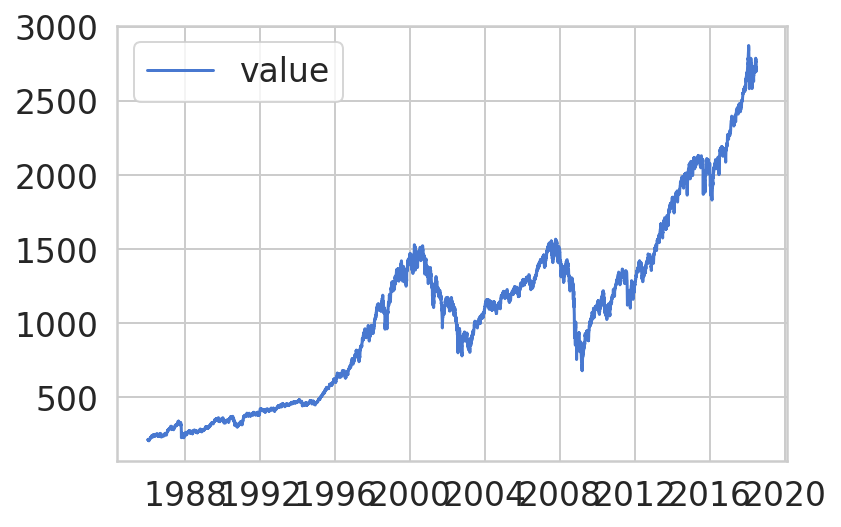

In [4]:
plt.plot(df, label='value')
plt.legend();

# Train the model

### Data Cleaning for training

In [5]:
TRAIN_EXCLUDE = 100 # Does not include given number of rows from the end
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:TRAIN_EXCLUDE], df.iloc[TRAIN_EXCLUDE:len(df)]
print(train.shape, test.shape)

(100, 1) (8092, 1)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/home/rissu/Programs/Anaconda3/envs/twitter/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/rissu/Programs/Anaconda3/envs/twitter/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(70, 30, 1)


In [9]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

2022-07-16 21:47:17.004774: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-16 21:47:17.004820: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-16 21:47:17.004848: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rissulenovo): /proc/driver/nvidia/version does not exist
2022-07-16 21:47:17.005089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
2/2 [==============================] - 7s 1s/step - loss: 0.6851 - val_loss: 0.7305
Epoch 2/10
2/2 [==============================] - 0s 121ms/step - loss: 0.6143 - val_loss: 0.6025
Epoch 3/10
2/2 [==============================] - 0s 82ms/step - loss: 0.5539 - val_loss: 0.4572
Epoch 4/10
2/2 [==============================] - 0s 74ms/step - loss: 0.4864 - val_loss: 0.3045
Epoch 5/10
2/2 [==============================] - 0s 71ms/step - loss: 0.4325 - val_loss: 0.2700
Epoch 6/10
2/2 [==============================] - 0s 74ms/step - loss: 0.4324 - val_loss: 0.3188
Epoch 7/10
2/2 [==============================] - 0s 69ms/step - loss: 0.4477 - val_loss: 0.3202
Epoch 8/10
2/2 [==============================] - 0s 67ms/step - loss: 0.4461 - val_loss: 0.2846
Epoch 9/10
2/2 [==============================] - 0s 68ms/step - loss: 0.4299 - val_loss: 0.2522
Epoch 10/10
2/2 [==============================] - 0s 70ms/step - loss: 0.4249 - val_loss: 0.2436


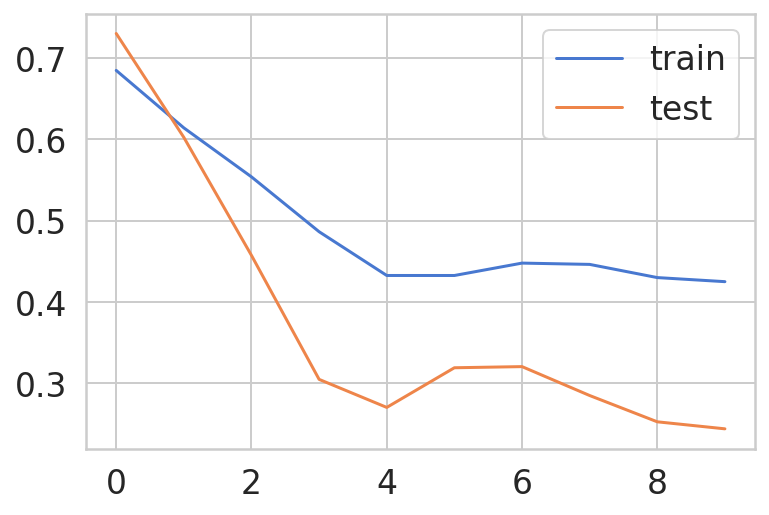

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [12]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

3/3 [==============================] - 1s 11ms/step


/home/rissu/Programs/Anaconda3/envs/twitter/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


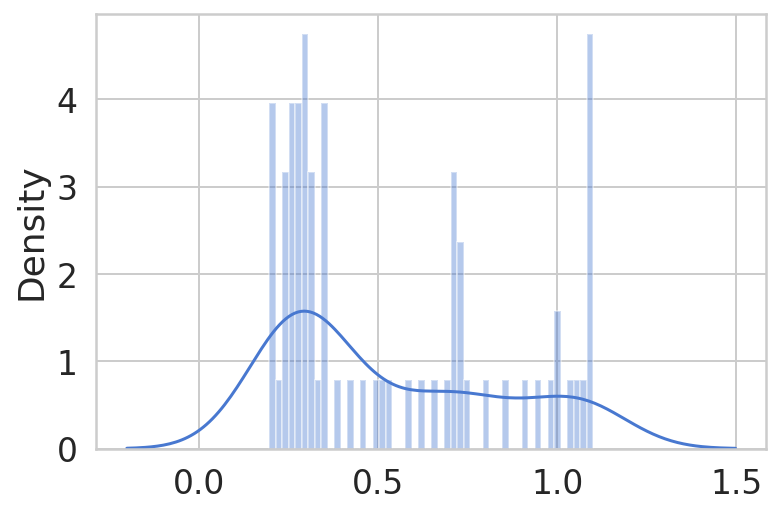

In [13]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [20]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

252/252 [==============================] - 3s 11ms/step
[[[  1.47768352]
  [  1.62998611]
  [  1.73935234]
  ...
  [  2.04800813]
  [  1.42097511]
  [  1.22168554]]

 [[  1.62998611]
  [  1.73935234]
  [  1.68831477]
  ...
  [  1.42097511]
  [  1.22168554]
  [  1.32133032]]

 [[  1.73935234]
  [  1.68831477]
  [  1.501177  ]
  ...
  [  1.22168554]
  [  1.32133032]
  [  1.33672261]]

 ...

 [[201.31002927]
  [202.2019716 ]
  [202.01321359]
  ...
  [204.82838123]
  [201.76531682]
  [202.25057881]]

 [[202.2019716 ]
  [202.01321359]
  [201.43316754]
  ...
  [201.76531682]
  [202.25057881]
  [200.35246722]]

 [[202.01321359]
  [201.43316754]
  [203.05664839]
  ...
  [202.25057881]
  [200.35246722]
  [201.70374768]]]


In [15]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

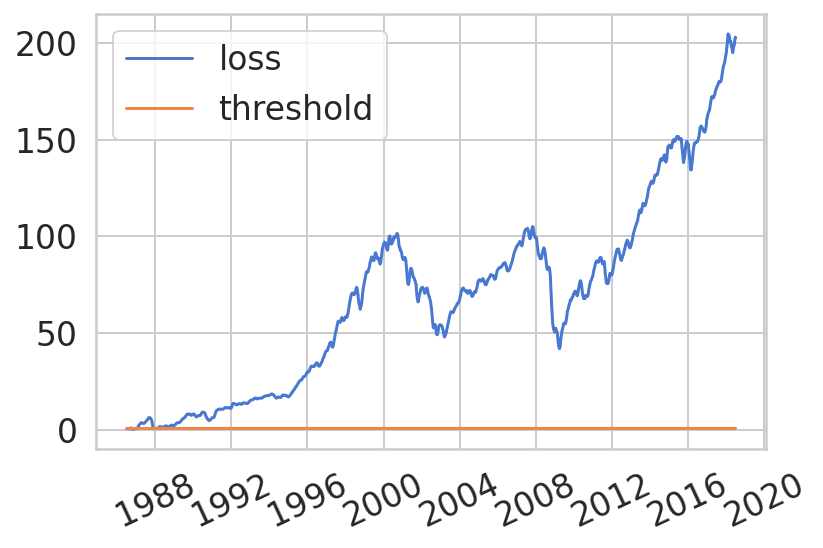

In [16]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [17]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

loss  threshold  anomaly     close
date                                              
1986-07-18  0.653971       0.65     True  0.797993
1986-07-21  0.661428       0.65     True  0.788271
1986-07-22  0.662731       0.65     True  0.945435
1986-07-23  0.663434       0.65     True  0.985130
1986-07-24  0.662552       0.65     True  0.926802

In [18]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

ValueError: Expected 2D array, got 1D array instead:
array=[  1.32133032   1.33672261   1.27272311 ... 200.35246722 201.70374768
 201.87063244].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.